In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.read_csv("medium_articles.csv") # https://www.kaggle.com/datasets/fabiochiusano/medium-articles?ref=machinelearningnuggets.com
df = df[["text"]]
df.head(),df.shape

(                                                text
 0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...
 1  Your Brain On Coronavirus\n\nA guide to the cu...
 2  Mind Your Nose\n\nHow smell training can chang...
 3  Passionate about the synergy between science a...
 4  You’ve heard of him, haven’t you? Phineas Gage...,
 (192368, 1))

In [ ]:
n = int(0.01 * len(df))  # first 1% will be train
train_examples = df[:n]
val_examples = df[n:n+500]

In [4]:
# for easy caching and batch creation
train_examples = tf.data.Dataset.from_tensor_slices((train_examples))
val_examples = tf.data.Dataset.from_tensor_slices((val_examples))

2025-05-17 20:48:23.622397: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-17 20:48:23.622422: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-17 20:48:23.622425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-17 20:48:23.622440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-17 20:48:23.622452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
max_features = 5000  # Limits the vocabulary size to the top n most frequent words.
BATCH_SIZE = 32
MAX_TOKENS = 128

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    max_tokens=max_features
)
vectorize_layer.adapt(train_examples, batch_size=None)

2025-05-17 20:48:33.270796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
vectorize_layer(["This is a sample sentence"])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[  16,    8,    5, 1192, 1354]])>

In [7]:
vocab_size = vectorize_layer.vocabulary_size()
print(vocab_size)  

vocab = vectorize_layer.get_vocabulary()
print(vocab[:10])      # top 10 most frequent tokens
print(vocab[1:5])      # excluding "[PAD]" which is index 0
print(vocab.index("the"))  # example: check token index


5000
['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'in', 'is', 'that']
['[UNK]', 'the', 'to', 'and']
2


In [8]:
def prepare_batch(data):
    x = vectorize_layer(data)
    x = x[:, :(MAX_TOKENS)]  # Trim to MAX_TOKENS
    X_train = x[:, :-1]  # Shift by one
    y_train = x[:, 1:]  # Shift by one
    return (X_train, y_train)

def make_batches(ds):
    return (
        ds.batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# Create training and validation set batches
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

for X_train, y_train in train_batches.take(1):
    break

print(X_train.shape)
print(y_train.shape)

(32, 127)
(32, 127)


## 🔄 During **training**, `X_train` and `y_train` look like this:

```text
Full sequences, not individual token pairs.
```

So it's this format:

### ✅ Matrix Format (Correct):

| Input (`X_train`)      | Target (`y_train`)     |
| ---------------------- | ---------------------- |
| the, cat, sat, on, the | cat, sat, on, the, mat |

In tokenized form:

```python
X_train = ["the", "cat", "sat", "on", "the"]
y_train = ["cat", "sat", "on", "the", "mat"]
```

* You train the model to **predict the entire next-token sequence in parallel**, not one token at a time.
* This allows training with **matrix multiplications and batching**, which is much faster.

---

## 🤖 So what does the model see during training?

### It sees:

* **`X_train`**: `[the, cat, sat, on, the]`
* At each time step `t`, it predicts the next word:

  * t = 0 → predict "cat"
  * t = 1 → predict "sat"
  * ...
  * t = 4 → predict "mat"

But this is all handled **in parallel**, thanks to masking.

---

## 🔒 Role of **causal mask**:

The causal mask ensures that at position `t`, the model **only uses** `x_0` to `x_t` to predict `y_t`.

It restricts each token's view to:

| Position | What model can use to predict y\_t |
| -------- | ---------------------------------- |
| t=0      | only "the"                         |
| t=1      | "the", "cat"                       |
| t=2      | "the", "cat", "sat"                |
| t=3      | "the", "cat", "sat", "on"          |
| ...      | ...                                |

So the earlier matrix you showed:

```text
| Current Token | Attends to |
```

...represents the **internal attention scope** the model uses **at each position in X\_train** to compute predictions for `y_train`.

---

## ✅ Final Summary:

| Concept                               | Format                                                                 |
| ------------------------------------- | ---------------------------------------------------------------------- |
| What the model is trained on          | Sequences like `X = ["the", "cat", "sat"]`, `y = ["cat", "sat", "on"]` |
| Does it see just one token at a time? | ❌ No — full sequences in parallel (efficient training)                 |
| How is cheating prevented?            | ✅ Causal mask limits each position’s view of the input                 |
| What’s predicted?                     | One token ahead at every position in `X_train`                         |



## 🚩 Step 1: Understanding more

Suppose we have this original sentence:

```text
["the", "cat", "sat", "on", "the", "mat"]
```

After tokenization and vectorization, it might become a tensor:

```python
x = [1, 23, 456, 12, 1, 987]
```

where numbers represent token IDs from the vocabulary.

You prepare the training pairs like this:

```python
X_train = x[:-1]  # All tokens except the last
y_train = x[1:]   # All tokens except the first
```

Thus, explicitly:

| Position (`t`) | X\_train (input) | y\_train (target next token) |
| -------------- | ---------------- | ---------------------------- |
| 0              | the (1)          | cat (23)                     |
| 1              | cat (23)         | sat (456)                    |
| 2              | sat (456)        | on (12)                      |
| 3              | on (12)          | the (1)                      |
| 4              | the (1)          | mat (987)                    |

---

## 🚩 Step 2: Why prepare data in this format?

The transformer (like GPT) is an **autoregressive model**. This means:

> **Given previous tokens (context), predict the next token.**

Training data is explicitly constructed to reflect this goal:

* At position `t`, the input is all previous context tokens (including the current token itself at position `t`).
* The target token is the next token at position `t+1`.

---

## 🚩 Step 3: Transformer model sees entire sequences, not single pairs

* The transformer is a parallel model, meaning it processes the entire input sequence simultaneously, not just one token at a time sequentially.
* For efficiency, during training, we provide batches of entire sequences:

```text
X_train: ["the", "cat", "sat", "on", "the"]
y_train: ["cat", "sat", "on", "the", "mat"]
```

* The model is asked simultaneously at every token position, "What is the next token?"

However, this creates a **challenge**:

* At position `t=2` (token `"sat"`), the correct next token is `"on"`.
* The model must **not** use future tokens (like `"on"` or `"mat"`) when predicting. This would constitute cheating.

---

## 🚩 Step 4: Role of causal masking (crucial nuance)

Here's where the subtlety occurs:

* Without special handling, the attention mechanism would allow each token at position `t` to see every other token at positions > `t`.
* To prevent this, we apply a **causal attention mask**.

### What does causal masking exactly do?

* Internally, the transformer computes attention scores between all pairs of tokens in the sequence, forming a square matrix of shape `(seq_len, seq_len)`.

For our example (5-token input):

```
       the    cat    sat     on    the  
the     ✔️     ❌      ❌     ❌     ❌
cat     ✔️     ✔️      ❌     ❌     ❌
sat     ✔️     ✔️      ✔️     ❌     ❌
on      ✔️     ✔️      ✔️     ✔️     ❌
the     ✔️     ✔️      ✔️     ✔️     ✔️
```

* ✔️ = allowed attention
* ❌ = disallowed attention (masked with negative infinity before softmax, effectively zeroing these out).

This ensures no token "peeks" into future positions.

---

## 🚩 Step 5: How exactly does transformer learn from masked attention?

Let's consider position-by-position carefully:

| Position (`t`) | Token | Allowed context (seen)              | Predict next token |
| -------------- | ----- | ----------------------------------- | ------------------ |
| 0              | the   | \["the"]                            | "cat"              |
| 1              | cat   | \["the", "cat"]                     | "sat"              |
| 2              | sat   | \["the", "cat", "sat"]              | "on"               |
| 3              | on    | \["the", "cat", "sat", "on"]        | "the"              |
| 4              | the   | \["the", "cat", "sat", "on", "the"] | "mat"              |

* At each step, the transformer computes attention **only to the allowed context** (due to masking).
* Using this context, it produces a probability distribution over the entire vocabulary predicting the next token (`y_train[t]`).

For example, at position `t=2` (token `"sat"`):

* Model sees tokens `"the", "cat", "sat"`.
* It must predict `"on"`.
* It learns weights (through backpropagation) to increase probability of `"on"` and reduce probabilities of incorrect tokens.

This training happens in parallel for every token in the sequence, speeding up computation drastically.

---

## 🚩 Step 6: Training and backpropagation — minute nuance

* Predictions at every position are compared against true next tokens (`y_train`) using a loss function like cross-entropy.
* Gradients are computed **jointly across all tokens in the sequence**.
* This gradient flows back through all attention heads, positional encodings, and embeddings simultaneously.
* The transformer’s parameters (weights) are updated to improve future predictions iteratively.

Thus, every training step makes the model incrementally better at predicting plausible next tokens given partial context.

---

## 🚩 Final recap of all nuances:

| Nuance                                      | Explanation                                                      |
| ------------------------------------------- | ---------------------------------------------------------------- |
| Data preparation                            | Shifted tokens to explicitly create input-target pairs           |
| Parallel processing                         | Transformer handles sequences simultaneously, not token-by-token |
| Causal masking                              | Critical to prevent model from peeking into future tokens        |
| Predictions at all positions simultaneously | Optimizes efficiency and utilizes GPU parallelization            |
| Joint backpropagation                       | Updates weights considering all positions simultaneously         |

---

This deep dive shows how a seemingly simple shift in data preparation (`X[:, :-1]`, `y[:, 1:]`) interacts intricately with the transformer’s causal masking and parallel computations to create a powerful predictive language model.


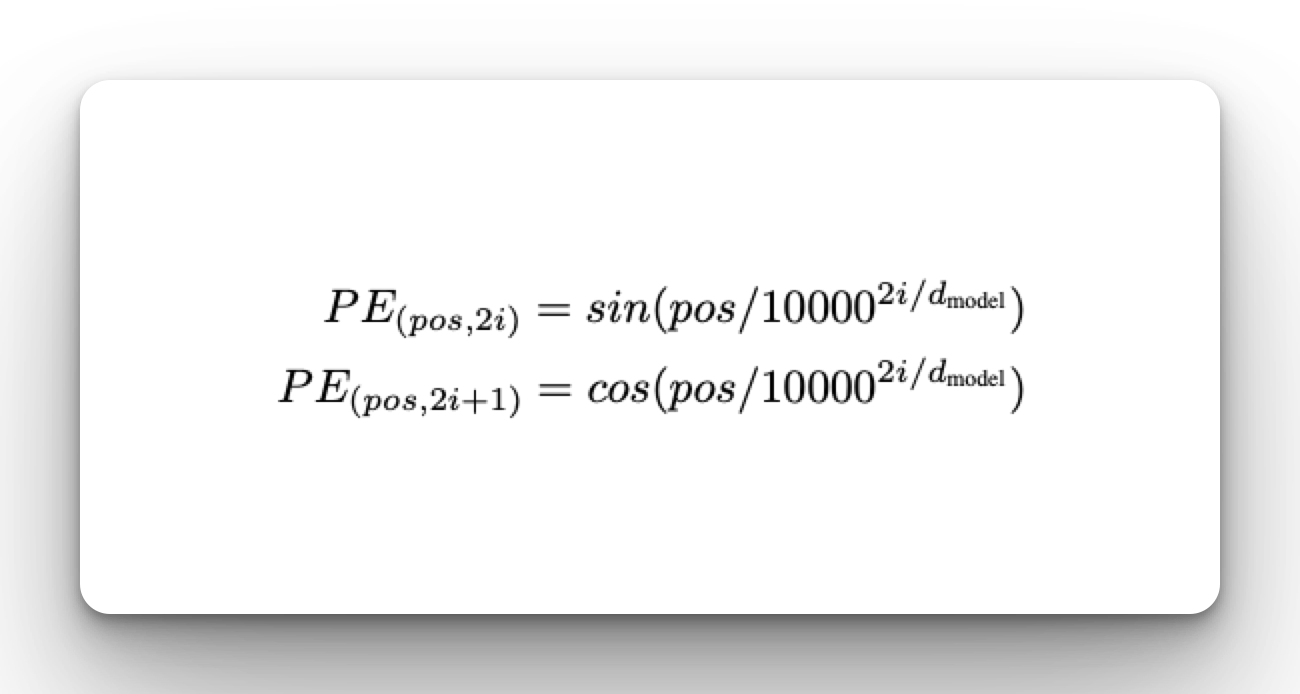

- We will use the Keras Embedding Layer to convert the tokens we created to vectors when passing them to the decoder. However, since the Transformer network has no recurrent layers, all the positional information would be lost. This is solved by introducing positional encoding into the network.

- The objective is to get the embedding vector of a token and add its position vector. That way, position information will not be lost.

- Word embedding is a technique used to represent documents with a dense vector representation. The vocabulary in these documents is mapped to real number vectors. Semantically similar words are mapped close to each other in the vector space.

- A word embedding represents the words in a text corpus with floating point values while considering the relationship between the different words. These relationships are learned when training the embeddings. The size of the embedding vector can be assigned manually. The Embedding layer is used for learning word embeddings in TensorFlow.


In [9]:
def positional_encoding(length, depth):
    """
    Generate sinusoidal positional encodings.
    
    Args:
        length (int): Maximum sequence length (e.g., 128).
        depth (int): Embedding size (d_model), must be even.
        
    Returns:
        pos_encoding: A tensor of shape (length, depth)
    """

    # Half the depth is for sin, half for cos
    depth = depth // 2

    # Shape: (length, 1) → positions 0 to length-1
    positions = np.arange(length)[:, np.newaxis]

    # Shape: (1, depth) → scaled frequencies for each dimension
    depths = np.arange(depth)[np.newaxis, :] / depth

    # Compute inverse frequency terms for each dimension
    angle_rates = 1 / (10000 ** depths)  # Shape: (1, depth)

    # Multiply each position by its corresponding frequency
    angle_rads = positions * angle_rates  # Shape: (length, depth)

    # Apply sin to even dimensions, cos to odd dimensions
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)  # (length, depth * 2)

    # Convert to TensorFlow tensor
    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Combines word/token embeddings with fixed positional encodings.
    
    Args:
        vocab_size (int): Vocabulary size (number of unique tokens).
        d_model (int): Embedding dimension.
    """
    def __init__(self, vocab_size, d_model):
        super().__init__()

        self.d_model = d_model

        # Learnable token embeddings
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=d_model, 
            mask_zero=True  # Ensures padding token is masked
        )

        # Precompute positional encodings up to max length (2048)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        # Pass through the mask from the embedding layer
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        """
        Args:
            x: Tensor of token indices → shape: (batch_size, sequence_length)
        
        Returns:
            Tensor of shape (batch_size, sequence_length, d_model)
        """

        # Get actual sequence length at runtime
        seq_length = tf.shape(x)[1]

        # Convert token indices to dense vectors → (batch_size, seq_len, d_model)
        x = self.embedding(x)

        # Scale embeddings to match positional encoding magnitude
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # Slice position encodings to match current input length
        # pos_encoding shape: (1, seq_len, d_model) after tf.newaxis
        x += self.pos_encoding[tf.newaxis, :seq_length, :]

        return x

### Question : 
If sine and cosine values in [-1, 1] for positonal embeddings and embedding values are mostly small (say, between -1 and 1), which means they are already in same scale. multiplying embedding values with √512 (d=512) tips off the scale.

### Answer :
Excellent observation — you're absolutely right to question that.

Let’s clear this up precisely:

---

### ✅ True:

* Yes, **sinusoidal positional encodings** lie in **$–1, 1$**.
* And the **embedding layer values** (before training) are typically initialized from a **normal distribution**, say `𝒩(0, 0.05)` or similar.

  * So their range is **much smaller** than $-1, 1$ — often more like $-0.1, 0.1$ initially.
* Hence, **positional encodings would dominate** the sum `x + pos_encoding` without scaling.

---

### 🔍 Why multiply embeddings by √d\_model?

This trick is **not about matching positional encoding scale**, but about:

#### 🔸1. **Balancing the variance**:

In the Transformer paper, embeddings are scaled by:

$$
x \gets x \cdot \sqrt{d_{\text{model}}}
$$

Because:

* The variance of the dot-product in attention becomes proportional to `d_model`.
* Without scaling, dot-products might have too small values → gradients vanish.
* Scaling the embeddings helps maintain stable gradients early in training.

#### 🔸2. **Making learned embeddings comparable to learned positional encodings (if learned)**:

In models that **learn positional embeddings** (vs. sinusoidal), both embeddings are from trainable layers → scaling ensures neither dominates.

---

### 📚 In summary:

| Point                           | Clarification                                                                                                                                                 |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Positional encodings            | Are fixed, with values in $-1, 1$                                                                                                                             |
| Embeddings                      | Initialized with very small values, often much **smaller** than 1                                                                                             |
| Scaling embeddings by √d\_model | Brings their **magnitude up** to balance the dot-product math in attention and to **prevent positional encodings from dominating** the sum `x + pos_encoding` |

---

So you were right that **if** both are in $-1, 1$, scaling may tip the balance — but in practice, **embeddings are much smaller**, and scaling helps them **match or exceed** the positional encoding scale and **stabilize learning**.

```python
x = x + self.pos_encoding[tf.newaxis, :length, :]
```

We'll walk through a **concrete mini-example** step by step, focusing only on **shapes and broadcasting**, so you see exactly why it works.

---

## 🧮 Let’s build a mini example

Assume:

* `batch_size = 2`
* `seq_len = 4`
* `d_model = 3` (i.e., 3-dimensional embeddings)

So:

### Step 1: After embedding

```python
x.shape = (2, 4, 3)
```

Meaning:

* 2 sequences (batch)
* Each sequence has 4 tokens
* Each token is a 3D vector

Visualized as:

```text
x = [
  [[e1, e2, e3], [e4, e5, e6], [e7, e8, e9], [e10, e11, e12]],  # sequence 1
  [[e13, e14, e15], [e16, e17, e18], ..., [e22, e23, e24]]      # sequence 2
]
```

---

### Step 2: Positional Encoding

```python
self.pos_encoding.shape = (2048, 3)  # Precomputed with 2048 positions, 3 dims
```

You only need the **first 4** positions because `seq_len = 4`.

So you slice:

```python
self.pos_encoding[:length, :]  → shape: (4, 3)
```

But you want to **add it to `x`, which has shape (2, 4, 3)**.

So you add a batch dimension:

```python
self.pos_encoding[tf.newaxis, :length, :]  → shape: (1, 4, 3)
```

---

### ✅ Now the addition:

You're adding:

* `x.shape = (2, 4, 3)`
* `pos.shape = (1, 4, 3)`

TensorFlow automatically **broadcasts the `1` in the first dimension** to match `2`.

So it's as if:

```python
x[0] += pos[0]
x[1] += pos[0]
```

Both sequences in the batch get the **same positional encodings** added at each time step.

---

### 🧠 Analogy:

You have a class of 2 students (batch = 2), each writing 4 words (`seq_len = 4`), and every word is a 3-dimensional vector (d\_model = 3).

You're adding **the same position info** to both students' 1st word, 2nd word, etc.

---

### 📐 Shape Summary

| Tensor                                      | Shape       | Meaning                                 |
| ------------------------------------------- | ----------- | --------------------------------------- |
| `x`                                         | `(2, 4, 3)` | 2 sequences, 4 tokens, 3-dim embeddings |
| `self.pos_encoding[:length, :]`             | `(4, 3)`    | Positional vectors for 4 positions      |
| `self.pos_encoding[tf.newaxis, :length, :]` | `(1, 4, 3)` | Add batch dimension for broadcasting    |
| `x + pos`                                   | `(2, 4, 3)` | ✅ Works via broadcasting                |


---

> **What is the role and significance of `length=2048` in**

> `self.pos_encoding = positional_encoding(length=2048, depth=d_model)`?


## 🔹 Quick Answer

* `length=2048` sets the **maximum number of positions** your model can handle in a sequence.
* It means: “precompute positional encodings for up to **2048 tokens** per input.”

So:

```python
self.pos_encoding.shape → (2048, d_model)
```

This tensor holds a **lookup table** of sinusoidal position vectors for position `0` to `2047`.

---

## 🧠 Why choose 2048?

### 1. ✅ **Efficiency**

Precomputing all 2048 position encodings **once** in `__init__` is faster than computing them dynamically for each input.

### 2. 🚫 **Hard limit on input length**

Your model can **only process up to 2048 tokens**. If your input sequence exceeds that, you'll get an error when slicing `self.pos_encoding[:length, :]`.

### 3. ⚠️ Trade-off: Memory vs. Flexibility

* Larger `length` → more memory used for storing `pos_encoding`
* Smaller `length` → limits your model’s max sequence length

---

## 📐 How it’s used at runtime:

```python
length = tf.shape(x)[1]  # Actual length of current input
x = x + self.pos_encoding[tf.newaxis, :length, :]  # Slice up to current length
```

Even if `self.pos_encoding` has 2048 rows, you only use the first `length` rows during any forward pass.

---

## 💡 Analogy

Think of `pos_encoding` as a **ruler with 2048 markings**.

Each token says:

> “I’m the 17th word in this sentence” → “I’ll take position vector #17”

Your model has a ruler that’s **2048 units long**. If the sentence is longer than 2048, there's no position marker available — the model can't measure that far.

---

## ✅ Best Practice

Choose `length=2048` if:

* You **expect long inputs** (e.g., GPT-2, BERT-large handle 1024+ tokens)
* Your model **won’t exceed** that max during training or inference

You could also make `length` a constructor argument:

```python
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_length=2048):
        ...
        self.pos_encoding = positional_encoding(length=max_length, depth=d_model)
```

---

## 🔚 Summary

| `length=2048`                        | Meaning                        |
| ------------------------------------ | ------------------------------ |
| Precomputes 2048 position vectors    | (from position 0 to 2047)      |
| Controls max input sequence length   | Model fails beyond 2048 tokens |
| Chosen for speed & fixed-size tensor | Sliced per input dynamically   |



# Set up attention layer in Keras

### Scaled Dot-Product attention

In the Transformer attention is computed using queries, keys, and values. The computation is done by weighting the sum of the values by mapping the key-value pairs with each value having a given weight.

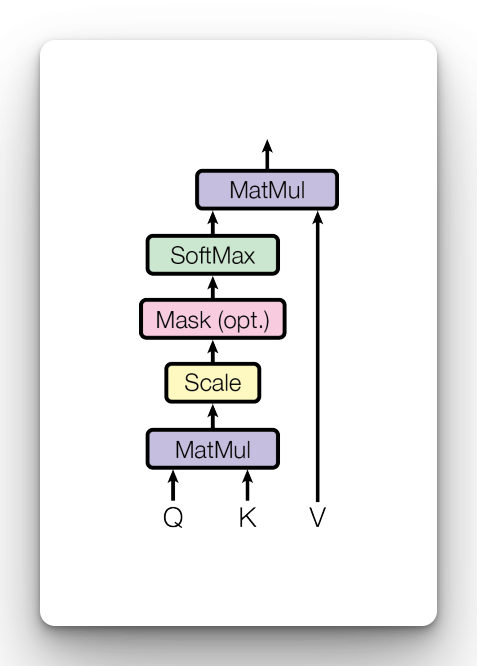

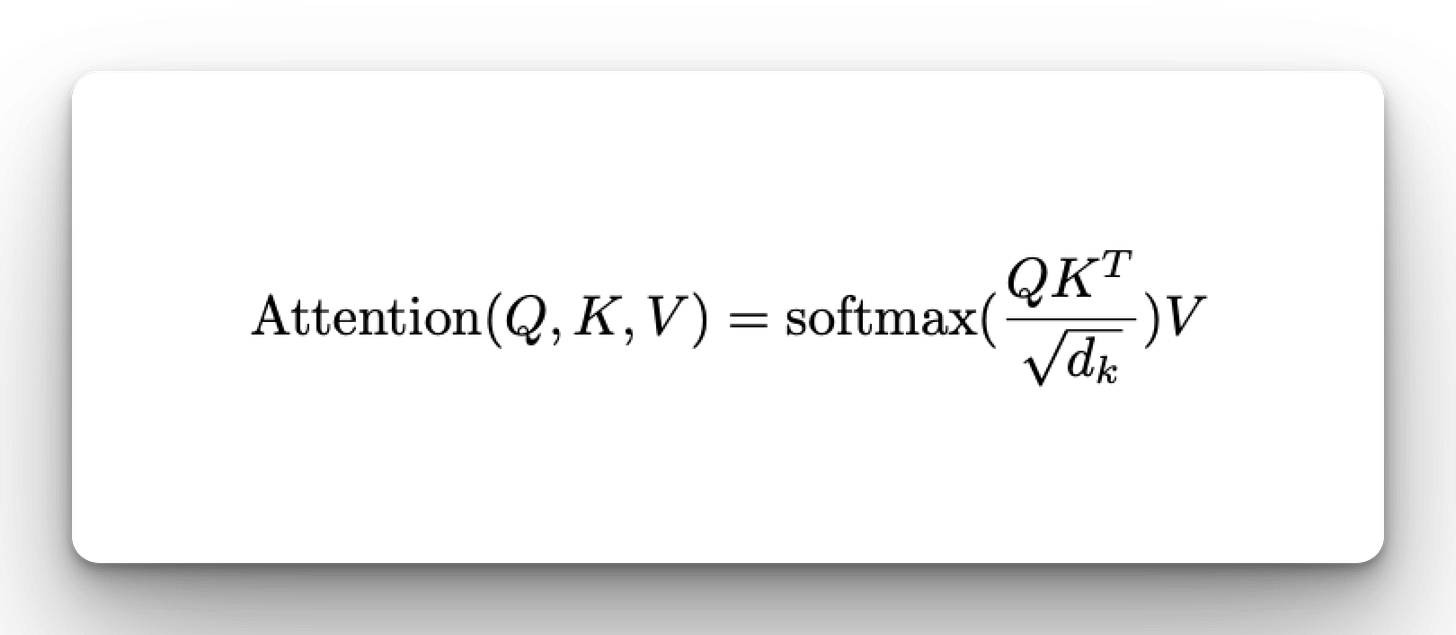

where:

- dk is the dimension of the key vector
- Q is the query matrix
- K and V are the key and value matrices
- Dividing by the square root of dk is a scaling factor that stabilizes gradients


To obtain Query, Key, and Value matrices the input query, key, and value are multiplied.

**Self-attention** comes from the factor each word in the sentence is scored against all the words. So a word can attend to itself. The scores are passed through a softmax function where they will sum to 1, making them easy to interpret as probabilities.


### Multi-head Attention

When we run multiple attention layers at the same time it leads to Multi-head Attention. This is done by running the attention layers at the same time, concatenating the results, and passing them to the feedforward layer.

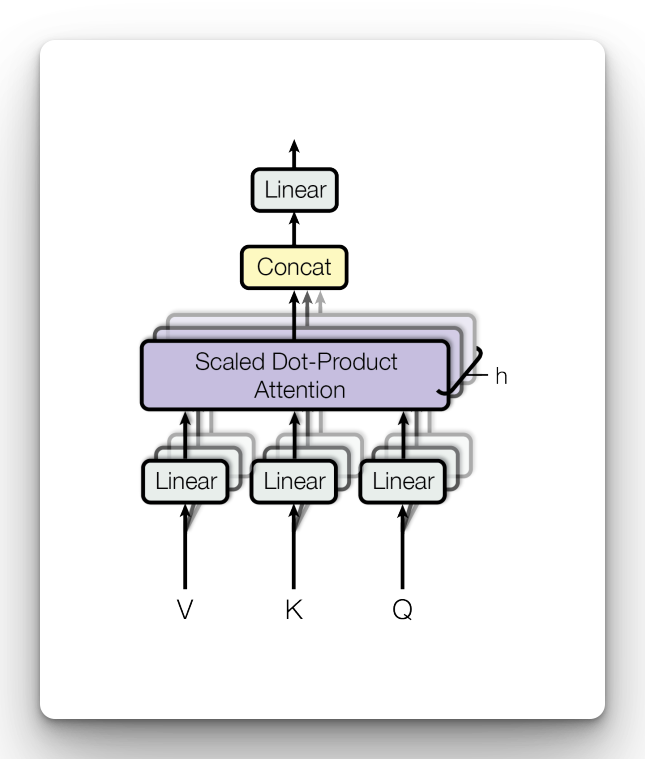

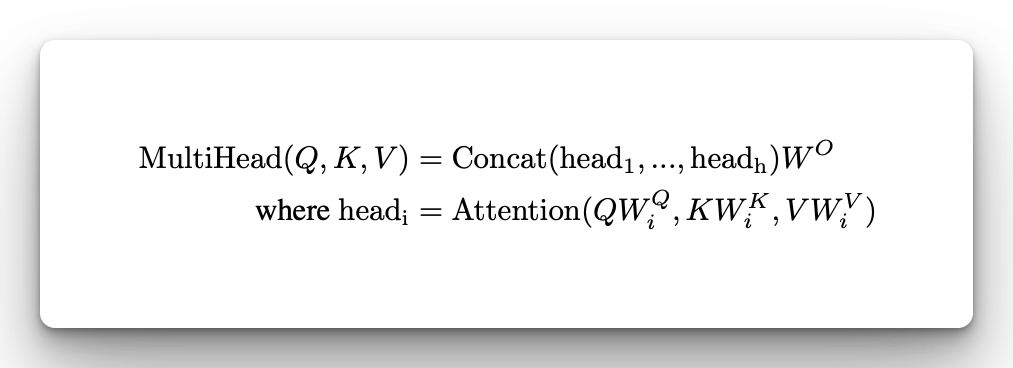

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Vanilla multi-head (scaled-dot-product) attention implemented from scratch.

    Args
    ----
    d_model     : int   – total embedding size (must be divisible by num_heads)  
    num_heads   : int   – number of attention heads  
    dropout     : float – dropout on attention weights (0.0 = no dropout)

    Call Signature
    --------------
    output, attn_scores = mha(
        query,                     # (B, T_q, d_model)
        value=None,                # (B, T_v, d_model)  – defaults to query
        key=None,                  # (B, T_k, d_model)  – defaults to value
        mask=None,                 # (B, 1, T_q, T_k) or (B, T_q, T_k)
        use_causal_mask=False,     # True → autoregressive causal mask
        training=None
    )
    """
    def __init__(self, d_model, num_heads, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model={d_model} must be divisible by num_heads={num_heads}"
            )

        self.d_model   = d_model
        self.num_heads = num_heads
        self.depth     = d_model // num_heads

        # Linear projections for Q, K, V and final output
        self.wq   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wk   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wv   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wo   = tf.keras.layers.Dense(d_model, use_bias=False)

        self.dropout = tf.keras.layers.Dropout(dropout)

    # ────────────────────────────────────────────────────────────────────────
    # Helpers
    # ────────────────────────────────────────────────────────────────────────
    def _split_heads(self, x, B):
        """
        Reshape (B, T, d_model) → (B, num_heads, T, depth)
        so we can run attention on each head in parallel.
        """
        x = tf.reshape(x, (B, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    @staticmethod
    def _scaled_dot_product_attention(q, k, v, mask, dropout):
        """
        Core attention: softmax(QKᵀ / √d_k) V
        Returns: (B, h, T_q, depth_v), (B, h, T_q, T_k)
        """
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)  # (B,h,T_q,T_k)

        if mask is not None:
            # broadcast automatically if mask rank < scores rank
            scores += (mask * -1e9)  # large negative → zero probability

        attn = tf.nn.softmax(scores, axis=-1)
        attn = dropout(attn)
        output = tf.matmul(attn, v)  # (B,h,T_q,depth)
        return output, attn

    # ────────────────────────────────────────────────────────────────────────
    # Forward pass
    # ────────────────────────────────────────────────────────────────────────
    def call(
        self,
        query,
        value=None,
        key=None,
        mask=None,
        use_causal_mask=False
    ):
        if value is None:
            value = query
        if key is None:
            key = value

        B = tf.shape(query)[0]

        # 1. Linear projections
        q = self.wq(query)   # (B, T_q, d_model)
        k = self.wk(key)     # (B, T_k, d_model)
        v = self.wv(value)   # (B, T_v, d_model)

        # 2. Reshape for multi-head
        q = self._split_heads(q, B)  # (B, h, T_q, depth)
        k = self._split_heads(k, B)  # (B, h, T_k, depth)
        v = self._split_heads(v, B)  # (B, h, T_v, depth)

        # 3. (Optional) Causal mask: block future positions
        if use_causal_mask:
            T_q = tf.shape(q)[2]
            T_k = tf.shape(k)[2]
            causal = tf.linalg.band_part(tf.ones((T_q, T_k)), -1, 0)  # lower-tri
            causal = 1.0 - causal  # 1 → masked
            causal = causal[tf.newaxis, tf.newaxis, :, :]  # (1,1,T_q,T_k)
            mask = causal if mask is None else tf.maximum(mask, causal)

        # 4. Scaled dot-product attention
        attn_out, attn_scores = self._scaled_dot_product_attention(
            q, k, v, mask, self.dropout
        )  # (B,h,T_q,depth), (B,h,T_q,T_k)

        # 5. Concatenate heads
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (B,T_q,h,depth)
        attn_out = tf.reshape(attn_out, (B, -1, self.d_model))  # (B,T_q,d_model)

        # 6. Final linear layer
        output = self.wo(attn_out)  # (B,T_q,d_model)

        # Store scores for later visualisation (optional)
        self.last_attn_scores = attn_scores  # (B,h,T_q,T_k)

        return output, attn_scores
    

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model=d_model,
                                      num_heads=num_heads,
                                      dropout=dropout)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output, attn_scores = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])  # residual
        return self.layernorm(x)

Here's a clear breakdown of **what**, **why**, and **how** everything happens in the given code for Multi-Head Attention:

---

## 🔹 **WHAT is Multi-Head Attention (MHA)?**

Multi-Head Attention allows a model to simultaneously pay attention to different aspects (features or patterns) of the input data. It's prominently used in Transformers for natural language processing, vision tasks, etc.

* **Scaled Dot-Product Attention**:

  $$
  \text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
  $$

* **Multi-Head**:

  * Splits attention mechanism into multiple parallel heads.
  * Allows the model to focus on different representation subspaces simultaneously.

---

## 🔹 **WHY is it happening?**

* **Parallelism**: Using multiple attention heads helps the model capture different types of relationships within the data simultaneously, improving representation quality.

* **Efficiency and Performance**: It allows the model to learn richer interactions without adding more complexity linearly.

* **Causal Masking**: Used in generative tasks (like language modeling) to prevent attending to future tokens, ensuring autoregressive behavior.

---

## 🔹 **HOW is it happening? (Step-by-Step)**

Here's a detailed breakdown of each part:

### 🟢 **Step 1: Linear Projections**

Each input (`query`, `key`, `value`) is transformed by separate linear layers into new spaces:

```python
q = self.wq(query)  # Queries: (B, T_q, d_model)
k = self.wk(key)    # Keys:    (B, T_k, d_model)
v = self.wv(value)  # Values:  (B, T_v, d_model)
```

These linear layers allow the model to learn optimal query-key-value transformations.

---

### 🟢 **Step 2: Splitting into Heads**

Split these transformed vectors into multiple heads:

* Before:

  $$
  (B, T, d_{\text{model}})
  $$

* After:

  $$
  (B, \text{num\_heads}, T, d_{\text{model}}/\text{num\_heads})
  $$

```python
def _split_heads(self, x, B):
    x = tf.reshape(x, (B, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
```

This allows computation of attention separately on multiple smaller subspaces.

---

### 🟢 **Step 3: Causal Masking (Optional)**

If `use_causal_mask` is `True`, the model constructs a triangular mask to prevent attention to future tokens. This enforces the autoregressive constraint (used in language models):

```python
if use_causal_mask:
    causal = tf.linalg.band_part(tf.ones((T_q, T_k)), -1, 0)
    causal = 1.0 - causal
    mask = causal if mask is None else tf.maximum(mask, causal)
```

* **Upper triangle** of mask: Positions set to negative infinity (very large negative number), effectively zeroing their probabilities after softmax.

---

### 🟢 **Step 4: Scaled Dot-Product Attention**

Compute attention scores, scale them, apply masking, and obtain attention weights:

```python
scores = tf.matmul(q, k, transpose_b=True) / sqrt(d_k)
scores += (mask * -1e9)  # Apply mask to scores

attn_weights = softmax(scores)
attn_weights = dropout(attn_weights)  # regularization
output = matmul(attn_weights, v)
```

* Softmax ensures attention weights sum up to 1, indicating probability distribution.
* Dropout randomly drops attention weights during training, reducing overfitting.

---

### 🟢 **Step 5: Concatenate Heads**

Combine results from different heads back into a single embedding:

```python
attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  
attn_out = tf.reshape(attn_out, (B, -1, self.d_model))
```

* Result shape becomes `(B, T, d_model)` again.

---

### 🟢 **Step 6: Final Linear Layer**

A final linear transformation combines concatenated features:

```python
output = self.wo(attn_out)
```

This step integrates multi-head information into a cohesive embedding vector.

---

### 🔹 **Class `BaseAttention` and `CausalSelfAttention`**

These are wrapper classes adding:

* **Residual Connections**: Preserve original information and ease gradient flow:

  ```python
  x = self.add([x, attn_output])
  ```

* **Layer Normalization**: Normalize outputs for stability:

  ```python
  self.layernorm(x)
  ```

`CausalSelfAttention` simply forces a causal mask, ensuring autoregressive attention:

```python
use_causal_mask=True
```

---

## 🎯 **Final Summary of Shapes:**

| Step                  | Shape                        | Operation                 |
| --------------------- | ---------------------------- | ------------------------- |
| Input Query           | `(B, T, d_model)`            |                           |
| After Linear Layers   | `(B, T, d_model)` each Q,K,V | `wq, wk, wv` Dense layers |
| After Splitting Heads | `(B, heads, T, depth)`       | `_split_heads`            |
| Attention Scores      | `(B, heads, T_q, T_k)`       | `matmul(Q,Kᵀ)`            |
| Attention Weights     | `(B, heads, T_q, T_k)`       | softmax + dropout         |
| Head Output           | `(B, heads, T_q, depth)`     | matmul(attn\_weights, V)  |
| Concatenated Output   | `(B, T_q, d_model)`          | reshape after transpose   |
| Final Output          | `(B, T_q, d_model)`          | Final Dense (`wo`)        |

---

## 🚩 **Overall Flow Visualization:**

```plaintext
Query/Key/Value → Linear → Split Heads → Compute Attention → Concat Heads → Linear → Output
                                     ↓ (optional mask)
                             Attention Weights
```

---

This complete process allows Transformers to capture complex patterns across data by simultaneously considering multiple representations and different attention contexts efficiently and effectively.


In [11]:
for x_batch, y_batch in train_batches.take(1):
    break

sample_csa = CausalSelfAttention(num_heads=2, d_model=64)

pe = PositionalEmbedding(vocab_size=max_features, d_model=64)
x_batch_emb = pe(x_batch)

print(x_batch_emb.shape)
print(sample_csa(x_batch_emb).shape)

(32, 127, 64)
(32, 127, 64)


/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


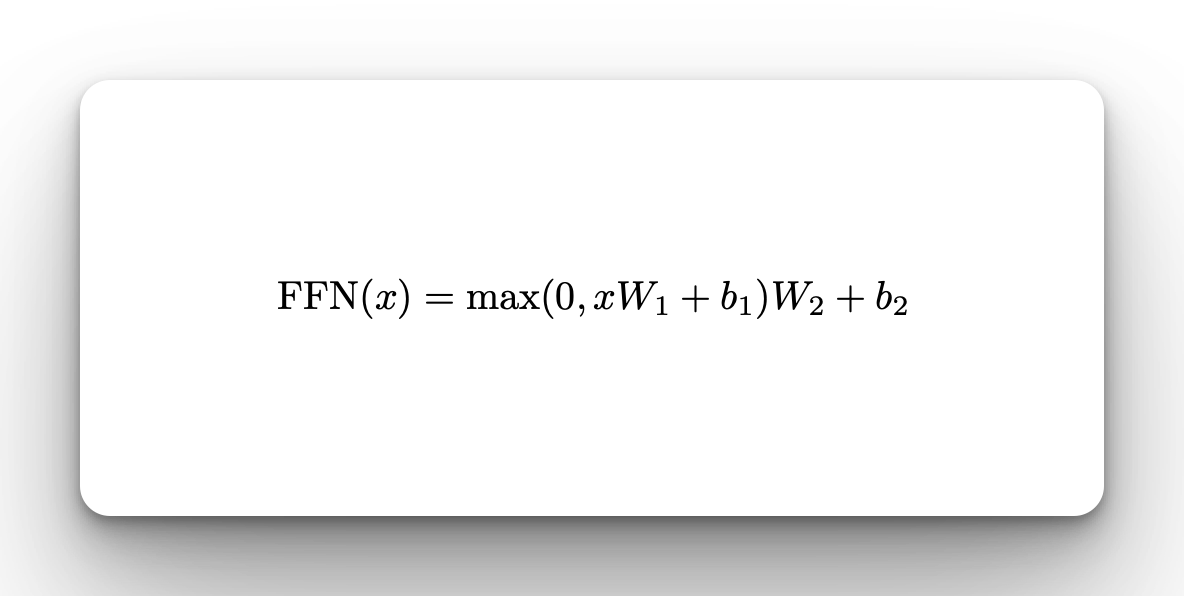

In [12]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(dff, activation="relu"),
                tf.keras.layers.Dense(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x
    

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads, d_model=d_model, dropout=dropout_rate
        )

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.causal_self_attention(x=x)
        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.causal_self_attention.last_attn_scores
        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x
    

# To define the Transformer decoder in TensorFlow you need:
#          1. The positional embedding layer
#          2. A stack of decoder layers


class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1
    ):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                           for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [20]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=1024, vocab_size=5000)

output = sample_decoder(x=x_batch)

# Print the shapes.
print(x_batch.shape)
print(output.shape)

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'multi_head_attention_8' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'causal_self_attention_8' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_layer_7' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not 

(32, 127)
(32, 127, 512)


In [21]:
class Transformer(tf.keras.Model):
    def __init__(
        self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1
    ):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            vocab_size=input_vocab_size,
            dropout_rate=dropout_rate,
        )

        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        x = inputs

        x = self.decoder(x)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [23]:
def masked_loss(label, pred):
    mask = label != 0  # Ignore padding token (assumed to be 0)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )
    loss = loss_object(label, pred)  # Shape: (batch, seq_len)
    mask = tf.cast(mask, dtype=loss.dtype)  # (batch, seq_len)
    loss *= mask  # Zero out padding loss
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Normalize
    return loss


def masked_accuracy(label, pred):
    # Step 1: Get the predicted token IDs by taking the argmax across the vocabulary dimension
    # pred shape = (batch_size, seq_len, vocab_size)
    # pred after argmax shape = (batch_size, seq_len)
    pred = tf.argmax(pred, axis=2) # vocab_size: a probability distribution (logits) over all possible words in the vocabulary

    # Step 2: Cast label to the same dtype as pred to allow comparison
    label = tf.cast(label, pred.dtype)

    # Step 3: Compare predicted tokens with true labels (element-wise equality)
    # match = True where prediction is correct
    match = label == pred

    # Step 4: Create a mask to ignore padding tokens (typically token ID 0 is reserved for padding)
    mask = label != 0  # mask = True for real tokens, False for padding

    # Step 5: Only consider matches where the token is not padding
    # Logical AND between match and mask to keep valid positions
    match = match & mask

    # Step 6: Cast boolean tensors to float for mathematical operations
    match = tf.cast(match, dtype=tf.float32)  # 1.0 for correct, 0.0 otherwise
    mask = tf.cast(mask, dtype=tf.float32)    # 1.0 for valid token, 0.0 for padding

    # Step 7: Compute accuracy = (correct predictions) / (number of valid tokens)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

'''

pred = tf.constant([
  [ [0.1, 0.6, 0.3],  # timestep 1
    [0.05, 0.1, 0.85] ]  # timestep 2
])  # shape = (1, 2, 3) → batch of 1, sequence length 2, vocab size 3


then :

tf.argmax(pred, axis=2) → [[1, 2]]

- At timestep 1 → index 1 is max

- At timestep 2 → index 2 is max

'''

'\n\npred = tf.constant([\n  [ [0.1, 0.6, 0.3],  # timestep 1\n    [0.05, 0.1, 0.85] ]  # timestep 2\n])  # shape = (1, 2, 3) → batch of 1, sequence length 2, vocab size 3\n\n\nthen :\n\ntf.argmax(pred, axis=2) → [[1, 2]]\n\n- At timestep 1 → index 1 is max\n\n- At timestep 2 → index 2 is max\n\n'

In [ ]:
transformer = Transformer(num_layers=3, d_model=128, num_heads=4, dff=256, input_vocab_size=5000)
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
history = transformer.fit(train_batches, epochs=10, validation_data=val_batches)

Epoch 1/10


/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'multi_head_attention_12' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'causal_self_attention_12' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'decoder_layer_11' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does n

In [18]:
class Generator(tf.Module):
    def __init__(
        self,
        tokenizer,
        vocabulary,
        transformer,
        max_new_tokens,
        temperature=0.0,
    ):
        self.tokenizer = tokenizer
        self.transformer = transformer
        self.vocabulary = vocabulary
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature

    def __call__(self, sentence, max_length=MAX_TOKENS):
        sentence = self.tokenizer(sentence)
        sentence = tf.expand_dims(sentence, axis=0)
        encoder_input = sentence
        # `tf.TensorArray` is required here (instead of a Python list), so that the
        # dynamic-loop can be traced by `tf.function`.
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        print(f"Generating {self.max_new_tokens} tokens")
        for i in tf.range(self.max_new_tokens):
            output = tf.transpose(output_array.stack())
            predictions = self.transformer(encoder_input, training=False)

            # Select the last token from the `seq_len` dimension.
            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            if self.temperature == 0.0:
                # greedy sampling, output always the same
                predicted_id = tf.argmax(predictions, axis=-1)
            else:
                predictions = predictions / self.temperature
                predicted_id = tf.random.categorical(predictions[0], num_samples=1)

            # Concatenate the `predicted_id` to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i + 1, predicted_id[0])
            encoder_input = tf.experimental.numpy.append(encoder_input, predicted_id[0])
            encoder_input = tf.expand_dims(encoder_input, axis=0)

        output = tf.transpose(output_array.stack())
        # The output shape is `(1, tokens)`.
        id_to_word = tf.keras.layers.StringLookup(
            vocabulary=self.vocabulary, mask_token="", oov_token="[UNK]", invert=True
        )

        print(f"Using temperature of {self.temperature}")
        text = id_to_word(output)
        tokens = output

        # `tf.function` prevents us from using the attention_weights that were
        # calculated on the last iteration of the loop.
        # So, recalculate them outside the loop.
        self.transformer(output[:, :-1], training=False)
        attention_weights = self.transformer.decoder.last_attn_scores

        return text, tokens, attention_weights

In [19]:
max_new_tokens = 50
temperature = 0.92
generator = Generator(
    vectorize_layer, vectorize_layer.get_vocabulary(), transformer, max_new_tokens, temperature, 
)
def print_generation(sentence, generated_text):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Generation":15s}: {generated_text}')
sentence = "Mind Your"
generated_text, generated_tokens, attention_weights = generator(sentence)
print_generation(sentence, generated_text)

Generating 50 tokens
Using temperature of 0.92
Input:         : Mind Your
Generation     : [[b'' b'lot' b'higher' b'insights' b'per' b'that' b'lifelong' b'writing'
  b'business' b'aggregation' b'are' b'to' b'blind' b'prior' b'by' b'felt'
  b'[UNK]' b'seemingly' b'track' b'on' b'why' b'function' b'adults'
  b'that' b'[UNK]' b'effect' b'choices' b'conversion' b'you' b'and'
  b'during' b'language' b'was' b'smart' b'if' b'endless' b'rock' b'worse'
  b'i' b'planning' b'translation' b'actually' b'about' b'2019' b'served'
  b'to' b'response' b'is' b'data' b'to' b'false']]
